In [2]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import line_search
import matplotlib.pyplot as plt

In [3]:
def cubicmin(a, fa, fpa, b, fb, c, fc):
     with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db, fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C

            # Check if the discriminant is non-negative
            if radical < 0:
                radical = 0

            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
     if not np.isfinite(xmin):
        return None
     return xmin

def quadmin(a, fa, fpa, b, fb):
    try:
        D, C, db = fa, fpa, b - a
        B = (fb - D - C * db) / (db * db)
        xmin = a - C / (2.0 * B)
    except ArithmeticError:
        return None
    return xmin if np.isfinite(xmin) else None

def zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo, phi, derphi, phi0, derphi0, c1, c2):
    maxiter, i, delta1, delta2, phi_rec, a_rec = 100, 0, 0.2, 0.1, phi0, 0

    while True:
        dalpha = a_hi - a_lo
        a, b = (a_hi, a_lo) if dalpha < 0 else (a_lo, a_hi)

        if (i > 0):
            cchk = delta1 * dalpha
            a_j = cubicmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi, a_rec, phi_rec)
        if (i == 0) or (a_j is None) or (a_j > b - cchk) or (a_j < a + cchk):
            qchk = delta2 * dalpha
            a_j = quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b - qchk) or (a_j < a + qchk):
                a_j = a_lo + 0.5 * dalpha

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1 * a_j * derphi0) or (phi_aj >= phi_lo):
            phi_rec, a_rec, a_hi, phi_hi = phi_hi, a_hi, a_j, phi_aj
        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2 * derphi0:
                return a_j, phi_aj, derphi_aj
            if derphi_aj * (a_hi - a_lo) >= 0:
                phi_rec, a_rec, a_hi, phi_hi = phi_hi, a_hi, a_lo, phi_lo
            else:
                phi_rec, a_rec = phi_lo, a_lo
            a_lo, phi_lo, derphi_lo = a_j, phi_aj, derphi_aj
        i += 1
        if i > maxiter:
            print('Failed to find a conforming step size')
            return None, None, None

def line_search_wolfe(fn, fnp, xk, pk, c1=1e-4, c2=0.9, amax=np.Inf, maxiter=10):
    func_it, grad_it, grad_0, grad_a = [0], [0], [None], [None]

    def phi(alpha):
        func_it[0] += 1
        return fn(xk + alpha * pk)

    def phip(alpha):
        grad_it[0] += 1
        grad_0[0], grad_a[0] = fnp(xk + alpha * pk), alpha
        return np.dot(grad_0[0], pk)

    phi_0, phip_0, a0, a1 = phi(0), phip(0), 0, 1.0

    if amax is not None:
        a1 = min(a1, amax)

    phi_a1, phi_a0, phip_a0 = phi(a1), phi_0, phip_0

    for i in range(maxiter):
        not_first_iteration = i > 0
        if (phi_a1 > phi_0 + c1 * a1 * phip_0) or ((phi_a1 >= phi_a0) and not_first_iteration):
            a_star, phi_star, phip_star = zoom(a0, a1, phi_a0, phi_a1, phip_a0, phi, phip, phi_0, phip_0, c1, c2)
            break

        phip_a1 = phip(a1)

        if (abs(phip_a1) <= -c2 * phip_0):
            a_star, phi_star, phip_star = a1, phi_a1, phip_a1
            break

        if phip_a1 >= 0:
            a_star, phi_star, phip_star = zoom(a0, a1, phi_a0, phi_a1, phip_a0, phi, phip, phi_0, phip_0, c1, c2)
            break

        a2 = 2 * a1
        if amax is not None:
            a2 = min(a2, amax)
        a0, a1, phi_a0, phi_a1, phip_a0 = a1, a2, phi_a1, phi(a2), phip_a1

    else:
        a_star, phi_star, phip_star = a1, phi_a1, None
        print('The line search algorithm did not converge')

    if phip_star is None:
        print('The line search algorithm did not converge')
    else:
        phip_star = grad_0[0]

    return a_star


def minimize_wolfe(fn, fnp, xk):

  pk = -fnp(xk)
  i = 1
  while np.linalg.norm(pk) > 1e-6:
    alpha = line_search_wolfe(fn, fnp, xk, pk)

    xk += alpha*pk
    pk = -fnp(xk)
    print("Iteration {0}:\txk value: {1}\tfunction value: {2}".format(i, xk, fn(xk)))
    i += 1

  return xk





In [4]:
def bfgs(fn, fnp, x0,iteration_limit, maxiter=100):
    n = len(x0)
    Hk = np.eye(n)
    xk = x0
    i = 1
    while i <= maxiter:
        pk = -np.dot(Hk, fnp(xk))
        alpha = line_search_wolfe(fn, fnp, xk, pk)
        xkp1 = xk + alpha * pk
        sk = xkp1 - xk
        yk = fnp(xkp1) - fnp(xk)
        rho_k = 1.0 / np.dot(yk, sk)
        A1 = np.eye(n) - rho_k * np.outer(sk, yk)
        A2 = np.eye(n) - rho_k * np.outer(yk, sk)
        Hk = np.dot(np.dot(A1, Hk), A2) + rho_k * np.outer(sk, sk)
        xk = xkp1
        print("Iteration {0}:\txk value: {1}\tfunction value: {2}".format(i, xk, fn(xk)))
        i += 1
        if i > iteration_limit:
          break
    return xk


In [5]:
# Objective function
def f(x):
    return 0.5 * (x[0]**2 + 9 * x[1]**2)

# Gradient of the objective function
def grad_f(x):
    return np.array([x[0], 9 * x[1]])
initial_guess = np.array([1.0, 1.0])
# Testing with the bfgs function
print("\nTesting bfgs:")
bfgs_result = bfgs(f, grad_f, initial_guess,2)
print("Optimal solution:", bfgs_result)
print("Optimal value:", f(bfgs_result))




Testing bfgs:
Iteration 1:	xk value: [ 0.88767123 -0.0109589 ]	function value: 0.3945205479452055
Iteration 2:	xk value: [-0.0097279  0.0001201]	function value: 4.738096278568903e-05
Optimal solution: [-0.0097279  0.0001201]
Optimal value: 4.738096278568903e-05


Iteration 1:	xk value: [ 0.88767123 -0.0109589 ]	function value: 0.3945205479452055
Iteration 2:	xk value: [-0.0097279  0.0001201]	function value: 4.738096278568903e-05
Iteration 1:	xk value: [ 0.         -0.00096078]	function value: 4.153947422307157e-06
Iteration 2:	xk value: [ 7.68269461e-04 -7.39510711e-05]	function value: 3.197284065843503e-07


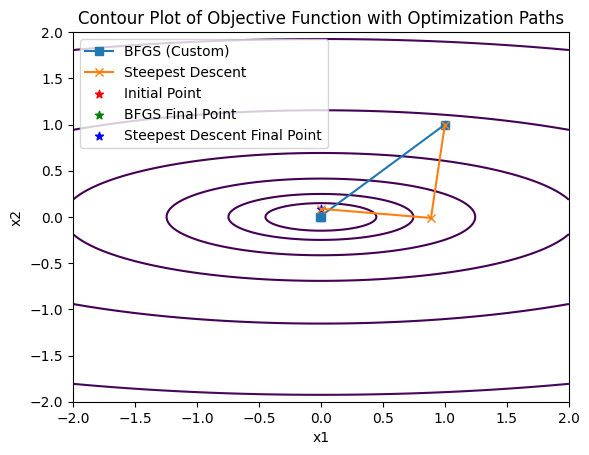

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Objective function
def f(x):
    A = np.array([[1, 0], [0, 9]])
    return 0.5 * x.T @ A @ x

# Gradient of the objective function
def gradient_f(x):
    A = np.array([[1, 0], [0, 9]])
    return A @ x

# BFGS algorithm with custom line search
def bfgs_algorithm(x0, iteration_limit, max_iterations=2):
    x_values = [x0]
    x = x0
    for k in range(max_iterations):
        # Use custom BFGS function
        x_new = bfgs(f, gradient_f, x, iteration_limit)
        x_values.append(x_new)

        # Update for the next iteration
        x = x_new

    return np.array(x_values)

# Steepest descent algorithm with custom line search
def steepest_descent_algorithm(x0, line_search_fn, max_iterations=2):
    x_values = [x0]
    x = x0
    for k in range(max_iterations):
        g = gradient_f(x)

        # Use custom line search
        alpha_k = line_search_fn(f, gradient_f, x, -g)

        x_new = x + alpha_k * (-g)
        x_values.append(x_new)

        # Update for the next iteration
        x = x_new

    return np.array(x_values)

# Generate contour plot
x1 = np.linspace(-2, 2, 400)
x2 = np.linspace(-2, 2, 400)
X1, X2 = np.meshgrid(x1, x2)
Z = 0.5 * (X1**2 + 9 * X2**2)

# Plot contours
plt.contour(X1, X2, Z, levels=np.logspace(-1, 3, 10))

# Run algorithms with custom line search
x0 = np.array([1.0, 1.0])
bfgs_path_custom = bfgs_algorithm(x0, iteration_limit=2, max_iterations=2)
steepest_descent_path = steepest_descent_algorithm(x0, line_search_wolfe, max_iterations=2)

# Plot paths
plt.plot(bfgs_path_custom[:, 0], bfgs_path_custom[:, 1], marker='s', label='BFGS (Custom)')
plt.plot(steepest_descent_path[:, 0], steepest_descent_path[:, 1], marker='x', label='Steepest Descent')

# Mark initial and final points
plt.scatter(*x0, color='red', marker='*', label='Initial Point')
plt.scatter(*bfgs_path_custom[-1], color='green', marker='*', label='BFGS Final Point')
plt.scatter(*steepest_descent_path[-1], color='blue', marker='*', label='Steepest Descent Final Point')

# Add labels and legend
plt.title('Contour Plot of Objective Function with Optimization Paths')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Show plot
plt.show()


Different way of getting figure.

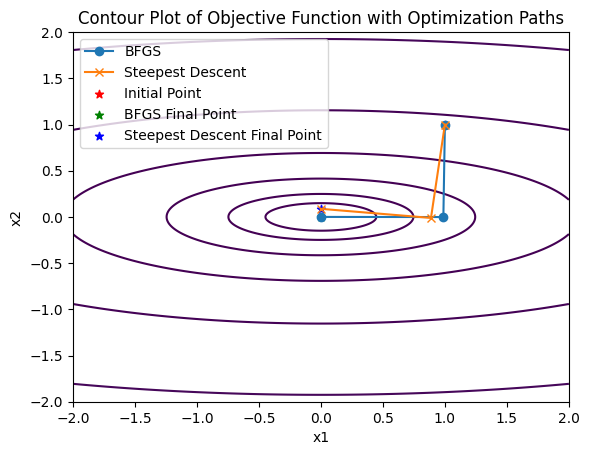

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Objective function
def f(x):
    A = np.array([[1, 0], [0, 9]])
    return 0.5 * x.T @ A @ x

# Gradient of the objective function
def gradient_f(x):
    A = np.array([[1, 0], [0, 9]])
    return A @ x

# BFGS algorithm with custom line search
def bfgs_algorithm(x0, line_search_fn, max_iterations=2):
    x_values = [x0]
    x = x0
    B = np.linalg.inv(np.array([[1, 0], [0, 1/9]]))  # Initial Hessian approximation
    for k in range(max_iterations):
        g = gradient_f(x)
        p = -B @ g

        # Use custom line search
        alpha_k = line_search_fn(f, gradient_f, x, p)

        x_new = x + alpha_k * p
        x_values.append(x_new)

        # BFGS update formula
        delta_x = x_new - x
        delta_g = gradient_f(x_new) - g
        B = B + np.outer(delta_x, delta_x) / np.dot(delta_x, delta_g) - \
            np.outer(B @ delta_g, B @ delta_g) / np.dot(delta_g, B @ delta_g)

        # Update for the next iteration
        x = x_new

    return np.array(x_values)

# Steepest descent algorithm with custom line search
def steepest_descent_algorithm(x0, line_search_fn, max_iterations=2):
    x_values = [x0]
    x = x0
    for k in range(max_iterations):
        g = gradient_f(x)

        # Use custom line search
        alpha_k = line_search_fn(f, gradient_f, x, -g)

        x_new = x + alpha_k * (-g)
        x_values.append(x_new)

        # Update for the next iteration
        x = x_new

    return np.array(x_values)

# Generate contour plot
x1 = np.linspace(-2, 2, 400)
x2 = np.linspace(-2, 2, 400)
X1, X2 = np.meshgrid(x1, x2)
Z = 0.5 * (X1**2 + 9 * X2**2)

# Plot contours
plt.contour(X1, X2, Z, levels=np.logspace(-1, 3, 10))

# Run algorithms with custom line search
x0 = np.array([1.0, 1.0])
bfgs_path = bfgs_algorithm(x0, line_search_wolfe, max_iterations=2)
steepest_descent_path = steepest_descent_algorithm(x0, line_search_wolfe, max_iterations=2)

# Plot paths
plt.plot(bfgs_path[:, 0], bfgs_path[:, 1], marker='o', label='BFGS')
plt.plot(steepest_descent_path[:, 0], steepest_descent_path[:, 1], marker='x', label='Steepest Descent')

# Mark initial and final points
plt.scatter(*x0, color='red', marker='*', label='Initial Point')
plt.scatter(*bfgs_path[-1], color='green', marker='*', label='BFGS Final Point')
plt.scatter(*steepest_descent_path[-1], color='blue', marker='*', label='Steepest Descent Final Point')

# Add labels and legend
plt.title('Contour Plot of Objective Function with Optimization Paths')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Show plot
plt.show()


It should be closer to 0

In [16]:
def bfgs(fn, fnp, x0,maxiter=6):
    n = len(x0)
    Hk = np.eye(n)
    xk = x0
    i = 1
    while i <= maxiter:
        pk = -np.dot(Hk, fnp(xk))
        alpha = line_search_wolfe(fn, fnp, xk, pk)
        xkp1 = xk + alpha * pk
        sk = xkp1 - xk
        yk = fnp(xkp1) - fnp(xk)
        rho_k = 1.0 / np.dot(yk, sk)
        A1 = np.eye(n) - rho_k * np.outer(sk, yk)
        A2 = np.eye(n) - rho_k * np.outer(yk, sk)
        Hk = np.dot(np.dot(A1, Hk), A2) + rho_k * np.outer(sk, sk)
        xk = xkp1
        print("Iteration {0}:\txk value: {1}\tfunction value: {2}".format(i, xk, fn(xk)))
        i += 1

    return xk

def dfp(fn, fnp, x0, maxiter=6):
    n = len(x0)
    Hk = np.eye(n)
    xk = x0
    i = 1
    while i <= maxiter:
        pk = -np.dot(Hk, fnp(xk))
        alpha = line_search_wolfe(fn, fnp, xk, pk)
        xkp1 = xk + alpha * pk
        sk = xkp1 - xk
        yk = fnp(xkp1) - fnp(xk)
        Hyk = np.dot(Hk, yk)

        term1 = np.outer(sk, sk) / np.dot(sk, yk)
        term2 = np.outer(Hyk, Hyk) / np.dot(yk, Hyk)

        Hk = Hk + term1 - term2

        xk = xkp1
        print("Iteration {0}:\txk value: {1}\tfunction value: {2}".format(i, xk, fn(xk)))
        i += 1

    return xk

# Test with the provided objective function
initial_guess = np.array([1.0, 1.0])
print("DFP results:\n")
dfp_result = dfp(f, grad_f, initial_guess)
print("\nOptimal solution:", dfp_result)
print("Optimal value:", f(dfp_result))
print("\nTesting bfgs:")
bfgs_result = bfgs(f, grad_f, initial_guess)
print("Optimal solution:", bfgs_result)
print("Optimal value:", f(bfgs_result))


DFP results:

Iteration 1:	xk value: [ 0.88767123 -0.0109589 ]	function value: 0.3945205479452055
Iteration 2:	xk value: [-1.08219596e-03  1.33604439e-05]	function value: 5.863773001242479e-07
Iteration 3:	xk value: [0.00000000e+00 1.69406589e-21]	function value: 1.2914366647217514e-41
Iteration 4:	xk value: [-1.58691737e-37 -1.50463277e-36]	function value: 1.020023049743338e-71
Iteration 5:	xk value: [0.00000000e+00 3.34095589e-52]	function value: 5.022893809345935e-103
Iteration 6:	xk value: [-5.21607115e-69  0.00000000e+00]	function value: 1.3603699117823355e-137

Optimal solution: [-5.21607115e-69  0.00000000e+00]
Optimal value: 1.3603699117823355e-137

Testing bfgs:
Iteration 1:	xk value: [ 0.88767123 -0.0109589 ]	function value: 0.3945205479452055
Iteration 2:	xk value: [-0.0097279  0.0001201]	function value: 4.738096278568903e-05
Iteration 3:	xk value: [ 0.00000000e+00 -1.35525272e-20]	function value: 8.265194654219209e-40
Iteration 4:	xk value: [2.11588983e-37 0.00000000e+00]	f